In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [2]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
## set train, validation, and test paths
train_path = '/content/gdrive/MyDrive/image-classification-deep-neural-networks-groceries/GroceryStoreDataset_1/dataset/train/Packages/' 
validation_path = '/content/gdrive/MyDrive/image-classification-deep-neural-networks-groceries/GroceryStoreDataset_1/dataset/val/Packages/'
test_path = '/content/gdrive/MyDrive/image-classification-deep-neural-networks-groceries/GroceryStoreDataset_1/dataset/test/Packages/'

In [6]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Alpro-Blueberry-Soyghurt', 'Alpro-Fresh-Soy-Milk',
                                                    'Alpro-Shelf-Soy-Milk', 'Alpro-Vanilla-Soyghurt',
                                                    'Arla-Ecological-Medium-Fat-Milk', 'Arla-Ecological-Sour-Cream',
                                                    'Arla-Lactose-Medium-Fat-Milk', 'Arla-Medium-Fat-Milk',
                                                    'Arla-Mild-Vanilla-Yoghurt', 'Arla-Natural-Mild-Low-Fat-Yoghurt',
                                                    'Arla-Natural-Yoghurt', 'Arla-Sour-Cream',
                                                    'Arla-Sour-Milk', 'Arla-Standard-Milk',
                                                    'Bravo-Apple-Juice', 'Bravo-Orange-Juice',
                                                    'Garant-Ecological-Medium-Fat-Milk', 'Garant-Ecological-Standard-Milk',
                                                    'God-Morgon-Apple-Juice', 'God-Morgon-Orange-Juice',
                                                    'God-Morgon-Orange-Red-Grapefruit-Juice', 'God-Morgon-Red-Grapefruit-Juice',
                                                    'Oatly-Natural-Oatghurt', 'Oatly-Oat-Milk',
                                                    'Tropicana-Apple-Juice', 'Tropicana-Golden-Grapefruit',
                                                    'Tropicana-Juice-Smooth', 'Tropicana-Mandarin-Morning',
                                                    'Valio-Vanilla-Yoghurt', 'Yoggi-Strawberry-Yoghurt',
                                                    'Yoggi-Vanilla-Yoghurt'], batch_size = 10)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Alpro-Blueberry-Soyghurt', 'Alpro-Fresh-Soy-Milk',
                                                    'Alpro-Shelf-Soy-Milk', 'Alpro-Vanilla-Soyghurt',
                                                    'Arla-Ecological-Medium-Fat-Milk', 'Arla-Ecological-Sour-Cream',
                                                    'Arla-Lactose-Medium-Fat-Milk', 'Arla-Medium-Fat-Milk',
                                                    'Arla-Mild-Vanilla-Yoghurt', 'Arla-Natural-Mild-Low-Fat-Yoghurt',
                                                    'Arla-Natural-Yoghurt', 'Arla-Sour-Cream',
                                                    'Arla-Sour-Milk', 'Arla-Standard-Milk',
                                                    'Bravo-Apple-Juice', 'Bravo-Orange-Juice',
                                                    'Garant-Ecological-Medium-Fat-Milk', 'Garant-Ecological-Standard-Milk',
                                                    'God-Morgon-Apple-Juice', 'God-Morgon-Orange-Juice',
                                                    'God-Morgon-Orange-Red-Grapefruit-Juice', 'God-Morgon-Red-Grapefruit-Juice',
                                                    'Oatly-Natural-Oatghurt', 'Oatly-Oat-Milk',
                                                    'Tropicana-Apple-Juice', 'Tropicana-Golden-Grapefruit',
                                                    'Tropicana-Juice-Smooth', 'Tropicana-Mandarin-Morning',
                                                    'Valio-Vanilla-Yoghurt', 'Yoggi-Strawberry-Yoghurt',
                                                    'Yoggi-Vanilla-Yoghurt'], batch_size = 5)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Alpro-Blueberry-Soyghurt', 'Alpro-Fresh-Soy-Milk',
                                                    'Alpro-Shelf-Soy-Milk', 'Alpro-Vanilla-Soyghurt',
                                                    'Arla-Ecological-Medium-Fat-Milk', 'Arla-Ecological-Sour-Cream',
                                                    'Arla-Lactose-Medium-Fat-Milk', 'Arla-Medium-Fat-Milk',
                                                    'Arla-Mild-Vanilla-Yoghurt', 'Arla-Natural-Mild-Low-Fat-Yoghurt',
                                                    'Arla-Natural-Yoghurt', 'Arla-Sour-Cream',
                                                    'Arla-Sour-Milk', 'Arla-Standard-Milk',
                                                    'Bravo-Apple-Juice', 'Bravo-Orange-Juice',
                                                    'Garant-Ecological-Medium-Fat-Milk', 'Garant-Ecological-Standard-Milk',
                                                    'God-Morgon-Apple-Juice', 'God-Morgon-Orange-Juice',
                                                    'God-Morgon-Orange-Red-Grapefruit-Juice', 'God-Morgon-Red-Grapefruit-Juice',
                                                    'Oatly-Natural-Oatghurt', 'Oatly-Oat-Milk',
                                                    'Tropicana-Apple-Juice', 'Tropicana-Golden-Grapefruit',
                                                    'Tropicana-Juice-Smooth', 'Tropicana-Mandarin-Morning',
                                                    'Valio-Vanilla-Yoghurt', 'Yoggi-Strawberry-Yoghurt',
                                                    'Yoggi-Vanilla-Yoghurt'], batch_size = 5)

Found 864 images belonging to 31 classes.
Found 415 images belonging to 31 classes.
Found 781 images belonging to 31 classes.


In [7]:
#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (10, 224, 224, 3)
labels batch shape: (10, 31)


In [8]:
from keras import layers
from keras import models

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(31, activation='softmax'))
model2.summary()
model2.save('/content/gdrive/MyDrive/image-classification-deep-neural-networks-groceries/model_1/groceries_basic_model_dropout')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [9]:
model_json = model2.to_json()
with open("/content/gdrive/MyDrive/image-classification-deep-neural-networks-groceries/model_1/model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data



train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')


## set steps per epoch for train
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

## set steps per epoch for validation
validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size


steps_per_epoch = len(train_filenames)//30
validation_steps = len(validation_filenames)//30 # if you have test data

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model2_fit_generator = model2.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_steps)




Found 864 images belonging to 31 classes.
Found 415 images belonging to 31 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
28/28 [==============================] - 178s 6s/step - loss: 3.4464 - acc: 0.0313 - val_loss: 3.3998 - val_acc: 0.1128
Epoch 2/50
28/28 [==============================] - 109s 4s/step - loss: 3.3601 - acc: 0.0895 - val_loss: 3.2387 - val_acc: 0.0872
Epoch 3/50
28/28 [==============================] - 107s 4s/step - loss: 3.1786 - acc: 0.1013 - val_loss: 3.0545 - val_acc: 0.1128
Epoch 4/50
28/28 [==============================] - 106s 4s/step - loss: 2.9994 - acc: 0.1138 - val_loss: 2.8009 - val_acc: 0.1359
Epoch 5/50
28/28 [==============================] - 105s 4s/step - loss: 2.8638 - acc: 0.1371 - val_loss: 2.5670 - val_acc: 0.2513
Epoch 6/50
28/28 [==============================] - 112s 4s/step - loss: 2.8211 - acc: 0.1711 - val_loss: 2.5065 - val_acc: 0.3026
Epoch 7/50
28/28 [==============================] - 107s 4s/step - loss: 2.6437 - acc: 0.2276 - val_loss: 2.2552 - val_acc: 0.3436
Epoch 8/50
28/28 [==============================] - 106s 4s/step - loss: 2.5027 - a

In [ ]:
model2_test_datagen = ImageDataGenerator(rescale=1./255)

model2_test_generator = model2_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = model2_test_generator.filenames
nb_samples = len(filenames)

model2_predict = model2.predict_generator(model2_test_generator,steps = nb_samples, verbose=2)



Found 781 images belonging to 31 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


781/781 - 226s


Confusion matrix, without normalization
[[ 1  1  0 19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  5  0  0  0  0]
 [ 0 20  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  3 24  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [13  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  5  0  0]
 [ 0  0  0  0 22  0  0  0  1  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0
   0  0  2  0  0  1  0]
 [ 0  0  0  1  0  7  0  0  0  0  1  6  2  4  0  0  0  2  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  8  0  0  0  0  0  0  0  0 14  0  8  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  1  0  0  0  0  3  4  7  0
   2  1  0  1  1  0  0]
 [ 0  0  0  0  0  0  1  0  5  6  0  1  0  3  0  0  0  0  0  0  0  0  7  0
   0

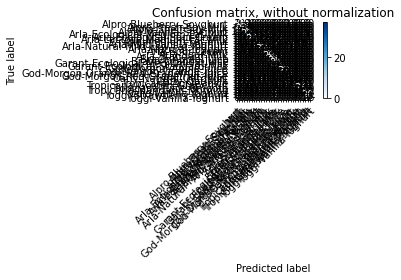

In [ ]:
y_true = model2_test_generator.classes
y_pred = model2_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Alpro-Blueberry-Soyghurt', 'Alpro-Fresh-Soy-Milk',
                                                    'Alpro-Shelf-Soy-Milk', 'Alpro-Vanilla-Soyghurt',
                                                    'Arla-Ecological-Medium-Fat-Milk', 'Arla-Ecological-Sour-Cream',
                                                    'Arla-Lactose-Medium-Fat-Milk', 'Arla-Medium-Fat-Milk',
                                                    'Arla-Mild-Vanilla-Yoghurt', 'Arla-Natural-Mild-Low-Fat-Yoghurt',
                                                    'Arla-Natural-Yoghurt', 'Arla-Sour-Cream',
                                                    'Arla-Sour-Milk', 'Arla-Standard-Milk',
                                                    'Bravo-Apple-Juice', 'Bravo-Orange-Juice',
                                                    'Garant-Ecological-Medium-Fat-Milk', 'Garant-Ecological-Standard-Milk',
                                                    'God-Morgon-Apple-Juice', 'God-Morgon-Orange-Juice',
                                                    'God-Morgon-Orange-Red-Grapefruit-Juice', 'God-Morgon-Red-Grapefruit-Juice',
                                                    'Oatly-Natural-Oatghurt', 'Oatly-Oat-Milk',
                                                    'Tropicana-Apple-Juice', 'Tropicana-Golden-Grapefruit',
                                                    'Tropicana-Juice-Smooth', 'Tropicana-Mandarin-Morning',
                                                    'Valio-Vanilla-Yoghurt', 'Yoggi-Strawberry-Yoghurt',
                                                    'Yoggi-Vanilla-Yoghurt'],
                      title='Confusion matrix, without normalization')
#plots(test_images, titles=test_labels)
print(filenames)

In [ ]:
model2.save('/content/gdrive/MyDrive/image-classification-deep-neural-networks-groceries/model_1/groceries_basic_model_dropout.h5')

## VGG Model

In [ ]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [ ]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights = 'imagenet')

In [ ]:
vgg_model.summary()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model.add(layer)
  
vgg_transfer_base_model.layers.pop()
for layer in vgg_transfer_base_model.layers:
  layer.trainable=False

vgg_transfer_base_model.add(Dense(1024, activation = 'relu'))
vgg_transfer_base_model.add(Dropout(0.5))
vgg_transfer_base_model.add(Dense(31, activation='softmax'))
vgg_transfer_base_model.summary()

In [ ]:
## data augmentation datagen
vgg_train_datagen_do = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test generator, required for prediction
vgg_test_datagen_do = ImageDataGenerator(rescale=1./255)

## train generator
vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_do = vgg_test_datagen_do.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


## set steps per epoch for train
train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size

## set steps per epoch for validation
validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size

## fit model
vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=50,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)